В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [9]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Часть 1. Подготовка данных (1 балл)

Так как старая ссылка на Google Drive с датасетом не работает, загрузим копию датасета [напрямую с Kaggle](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small)

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 3.99G/3.99G [03:14<00:00, 28.2MB/s]
100% 3.99G/3.99G [03:14<00:00, 22.0MB/s]


In [5]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

In [6]:
DATA_DIR = './images/'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
def get_dataloader(image_size, batch_size, device):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """

    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
    return DeviceDataLoader(train_dl, device)

In [13]:
image_size = 128
batch_size = 64

train_loader = get_dataloader(image_size, batch_size, device)

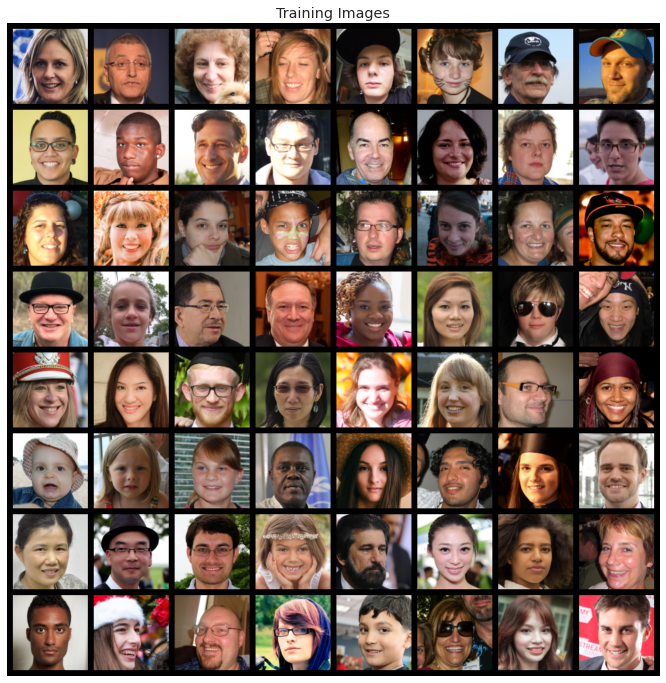

In [16]:
first_batch = next(iter(train_loader))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(first_batch[0][:64], padding=10, normalize=True).cpu(), (1, 2, 0)))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Возьмем за основу DCGAN из [официальной документации PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) 

In [18]:
num_channels = 3
discriminator_feature_maps = 64

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
discriminator = nn.Sequential(
    # input is (nc) x 64 x 64
    nn.Conv2d(num_channels, discriminator_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf) x 32 x 32
    nn.Conv2d(discriminator_feature_maps, discriminator_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf * 2) x 16 x 16
    nn.Conv2d(discriminator_feature_maps * 2, discriminator_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf * 4) x 8 x 8
    nn.Conv2d(discriminator_feature_maps * 4, discriminator_feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf * 8) x 4 x 4
    nn.Conv2d(discriminator_feature_maps * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
)

In [ ]:
latent_size = ... # choose latent size

generator = ...

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELOSS()
}

In [ ]:
def fit(model, criterion, epochs, lr):
  # TODO: build optimizers and train your GAN
  pass

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  pass

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: